In [101]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib import axes

#Functions definition

In [3]:
def MaxDD(returns,window):
  cum_returns=(1+returns).cumprod()
  rolling_max=cum_returns.rolling(window,min_periods=1).max()
  drawdown=cum_returns/rolling_max-1
  max_dd=drawdown.min()
  return max_dd,drawdown

In [98]:

def SharpeRatio(returns,rf):
  '''ret=(1+returns).prod()**(252/len(returns))-1
  std=returns.std()*np.sqrt(252)
  sharpe=(ret-rf)/std'''
  rf_daily=(1+rf)**(1/252)-1
  excess_returns=returns-rf_daily
  sharpe=(excess_returns.mean()*252)/(excess_returns.std()*np.sqrt(252))
  return sharpe

def InformationRatio(returns):
  r = returns[['FSLCX','^GSPC','^RUT']].dropna()
  active_ret={}
  tev={}
  for benchmark in ['^GSPC','^RUT']:
    daily_diff=r['FSLCX']-r[benchmark]
    active_ret[benchmark]=daily_diff.mean()*252
    tev[benchmark]=daily_diff.std()*np.sqrt(252)

  active_ret=pd.Series(active_ret)
  tev=pd.Series(tev)
  info=active_ret/tev
  return pd.Series(info, index=['^GSPC','^RUT'])

def SortinoRatio(returns,rf):
  rf_daily=(1+rf)**(1/252)-1
  excess_returns=returns-rf_daily
  downside=np.where(excess_returns<0,excess_returns,0)
  downside_deviation=np.sqrt((downside**2).mean())*np.sqrt(252)
  sortino=(excess_returns.mean()*252)/downside_deviation
  return sortino

def get_performance_metrics(ret_df, rf):
  metrics = pd.DataFrame()
  for col in ret_df.columns:
    metrics.loc[col, 'Sharpe'] = SharpeRatio(ret_df[col], rf)
    metrics.loc[col, 'Sortino'] = SortinoRatio(ret_df[col], rf)
    metrics.loc[col, 'MaxDD'] = MaxDD(ret_df[col], 20)[0]
  return metrics

def risk_decompositon(rf,fund_ret,ben_ret):
  rf_daily=(1+rf)**(1/252)-1
  #Rp​−Rf​=α+β(Rm​−Rf​)+ϵ
  X={}
  model={}
  regression={}
  excess_returns=fund_ret-rf_daily
  for benchmark in ['^GSPC','^RUT']:
    X[benchmark]=sm.add_constant(ben_ret[benchmark]-rf_daily)
    model[benchmark]=sm.OLS(excess_returns,X[benchmark]).fit()
    alpha=model[benchmark].params.iloc[0]
    beta=model[benchmark].params.iloc[1]
    Annualized_alpha=(1+alpha)**252-1
    r_squared=model[benchmark].rsquared

    regression[benchmark]={
        'Alpha':Annualized_alpha,
        'Beta':beta,
        'R-squared':r_squared
    }
  return pd.DataFrame(regression)

def rolling_beta(fund_ret,ben_ret,rf,window):
  rf=(1+rf)**(1/252)-1
  fund_exc=fund_ret-rf
  #Beta=Cov(fund,ben)/var(ben)
  betas=pd.DataFrame(index=fund_ret.index[window:],columns=['^GSPC','^RUT'])
  for benchmark in ['^GSPC','^RUT']:
    ben_ex=ben_ret[benchmark]-rf
    rolling_var=ben_ex.rolling(window).var()
    rolling_cov = fund_exc.rolling(window).cov(ben_ex)
    betas[benchmark]=rolling_cov/rolling_var
  return betas.dropna()

def rolling_tev(fund_ret,ben_ret,window):
  active_ret=fund_ret.sub(ben_ret,axis=0)
  rolling_tev=active_ret.rolling(window).std()*np.sqrt(252)
  return rolling_tev.dropna()

def distribution(returns):
  colors = sns.color_palette("husl", len(returns.columns))
  plt.figure(figsize=(10,6))
  for i,col in enumerate(returns.columns):
    sns.kdeplot(returns[col],label=col,fill=True)
    plt.axvline(returns[col].mean(),color=colors[i],linestyle='--',alpha=1, linewidth=0.3)

  plt.title('Distribution of Returns')
  plt.xlabel('Returns')
  plt.ylabel('Density')
  plt.legend()
  plt.show()
  return

def plt_histogram(returns):
  fix,axes=plt.subplots(nrows=1,ncols=3,figsize=(15,5),sharey=True)
  colors=sns.color_palette("husl",len(returns.columns))
  for i,col in enumerate(returns.columns):
    axes[i].hist(returns[col],bins=40,alpha=0.5,color=colors[i],label=col)
    axes[i].axvline(returns[col].mean(),color=colors[i],linestyle='--',alpha=1, linewidth=0.3)
    axes[i].set_title(f'{col} Histogram')
    axes[i].set_xlabel('Returns')
    axes[i].set_ylabel('Frequency')

#Variable set up

In [5]:
tickers=['FSLCX','^RUT','^GSPC']#Fidelity small cap index, russell 2000 index, sp 500
risk_free=[4.79/100,5.4/100,4.69/100]
prices=pd.DataFrame()
start_date='2022-11-01'
end_date='2024-10-31'
window=20
prices=yf.download(tickers,start_date,end_date,interval='1d',auto_adjust=True)['Close']

[*********************100%***********************]  3 of 3 completed


In [6]:
#2022-11-01 to 2024-10-31
returns=prices.pct_change().dropna()
cum_returns=(1+returns).cumprod()

In [7]:
#2022-11-01 to 2023-10-31
returns_1st=returns.loc['2022-11-01':'2023-10-31']
cum_returns_1st=cum_returns.loc['2022-11-01':'2023-10-31']
#2023-11-01 to 2024-10-31
returns_2nd=returns.loc['2023-11-01':'2024-10-31']
cum_returns_2nd=cum_returns.loc['2023-11-01':'2024-10-31']

#Performance overwiew



##First year: 2022-11-01 to 2023-10-31

In [8]:
len_year=len(returns_1st)/252

In [9]:
summary_firstPeriod=pd.DataFrame({
    'Annualized Return': (1+returns_1st).prod()**(1/len_year)-1,#annual return for the first period
    'Annualized Volatility':returns_1st.std()*np.sqrt(252),#annual volatility for the first period
    'Maximum DD 4-week': MaxDD(returns_1st,20)[0]
})

In [10]:
summary_firstPeriod

,Annualized Return,Annualized Volatility,Maximum DD 4-week
Ticker,,,
FSLCX,-0.049642,0.200405,-0.124614
^GSPC,0.088306,0.155830,-0.072765
^RUT,-0.102918,0.203406,-0.113273


Cumulative returns for the Fund, the Russel 2000 and the S&P500

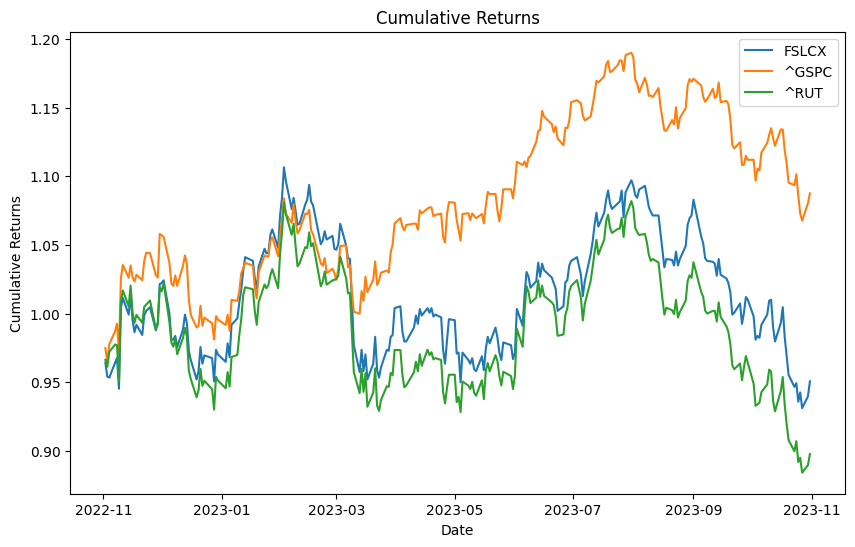

In [11]:
plt.figure(figsize=(10,6))
plt.plot(cum_returns_1st)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(cum_returns_1st.columns)
plt.show()

Volatility of the returns of the Fund, the Russel 2000 and the S&P500

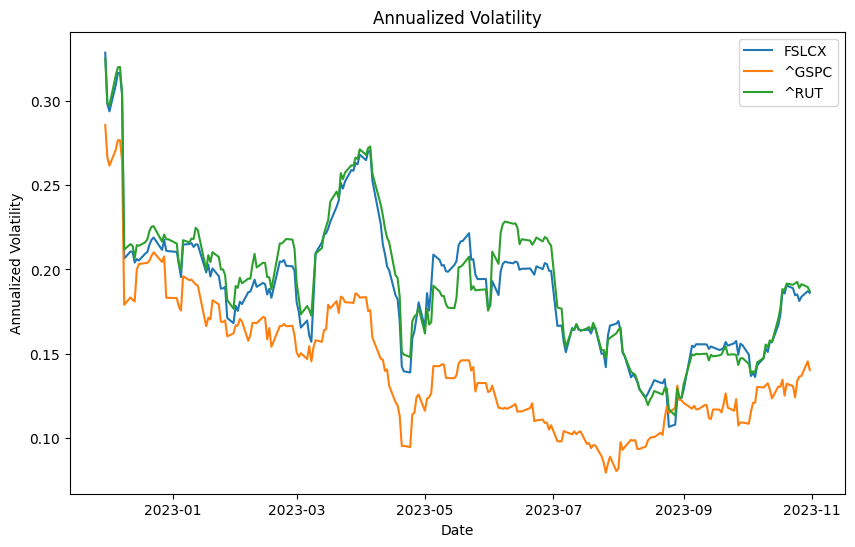

In [12]:
vol_1st=returns_1st.rolling(window).std()*np.sqrt(252)
plt.figure(figsize=(10,6))
plt.plot(vol_1st)
plt.title('Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend(vol_1st.columns)
plt.show()

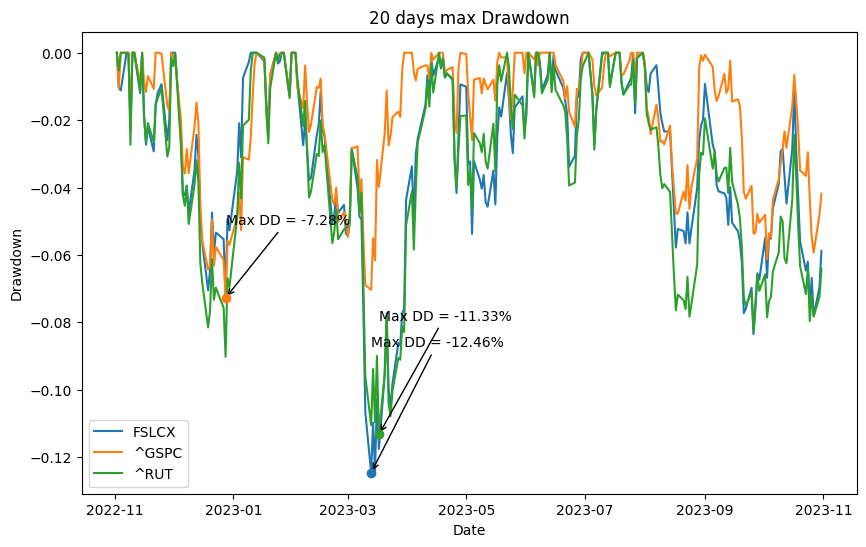

In [41]:
dd_1st=MaxDD(returns_1st,20)[1]
plt.figure(figsize=(10,6))
plt.plot(dd_1st, label='Drawdown')

for col in dd_1st.columns:
  plt.scatter(
      dd_1st[col].idxmin(),
      dd_1st[col].min(),
      zorder=5
  )

  plt.annotate(
      f"Max DD = {dd_1st[col].min():.2%}",
      xy=(dd_1st[col].idxmin(), dd_1st[col].min()),
      xytext=(dd_1st[col].idxmin(), dd_1st[col].min() * 0.7),
      arrowprops=dict(arrowstyle="->"),
  )

plt.title('20 days max Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend(dd_1st.columns)
plt.show()


##Second year: 2023-11-01 to 2024-10-31

In [14]:
len_year=len(returns_2nd)/252
summary_secondPeriod=pd.DataFrame({
    'Annualized Return': (1+returns_2nd).prod()**(1/len_year)-1,#annual return for the second period
    'Annualized Volatility':returns_2nd.std()*np.sqrt(252),#annual volatility for the second period
    'Maximum DD 4-week': MaxDD(returns_2nd,20)[0]
})

In [15]:
summary_secondPeriod

,Annualized Return,Annualized Volatility,Maximum DD 4-week
Ticker,,,
FSLCX,0.346777,0.187977,-0.091815
^GSPC,0.388059,0.121171,-0.084851
^RUT,0.344940,0.210250,-0.100969


Cumulative returns for the Fund, the Russel 2000 and the S&P500

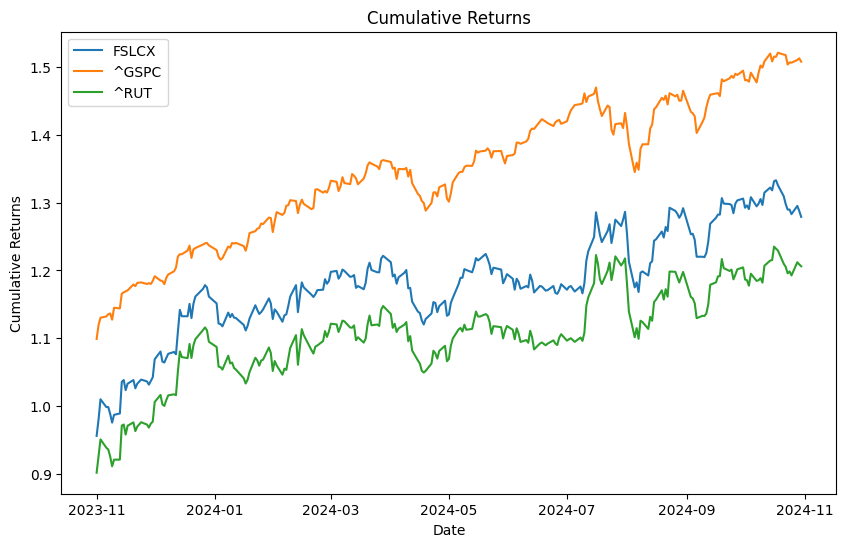

In [42]:
plt.figure(figsize=(10,6))
plt.plot(cum_returns_2nd)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(cum_returns_2nd.columns)
plt.show()

Volatility of the returns of the Fund, the Russel 2000 and the S&P500

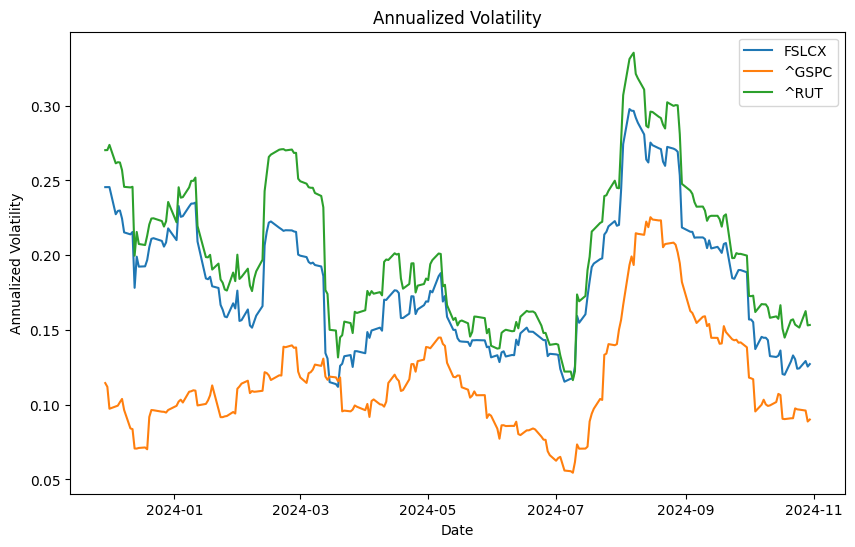

In [17]:
vol_2nd=returns_2nd.rolling(window).std()*np.sqrt(252)
plt.figure(figsize=(10,6))
plt.plot(vol_2nd)
plt.title('Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend(vol_2nd.columns)
plt.show()

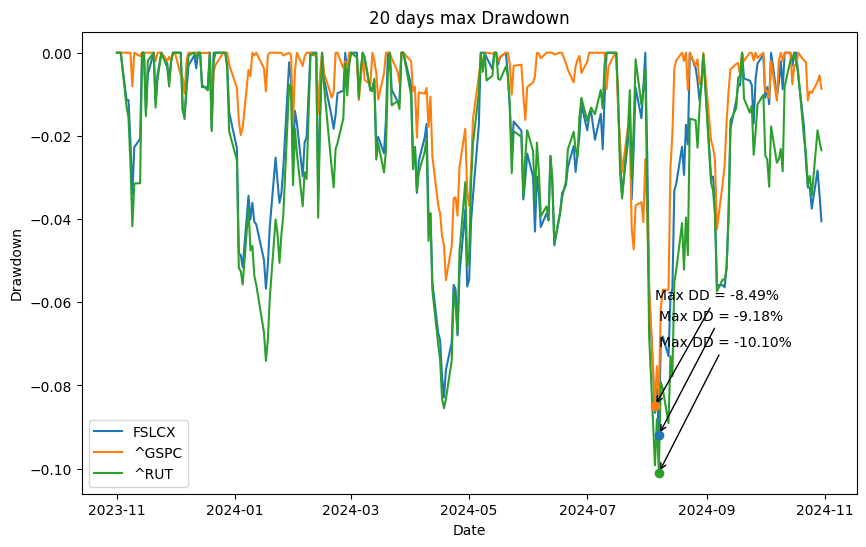

In [18]:
dd_2nd=MaxDD(returns_2nd,20)[1]
plt.figure(figsize=(10,6))
plt.plot(dd_2nd, label='Drawdown')

for col in dd_2nd.columns:
    plt.scatter(
        dd_2nd[col].idxmin(),
        dd_2nd[col].min(),
        zorder=5
    )
    plt.annotate(
      f"Max DD = {dd_2nd[col].min():.2%}",
      xy=(dd_2nd[col].idxmin(), dd_2nd[col].min()),
      xytext=(dd_2nd[col].idxmin(), dd_2nd[col].min() * 0.7),
      arrowprops=dict(arrowstyle="->"),
  )

plt.title('20 days max Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend(dd_2nd.columns)
plt.show()

##Two years: period 2022-11-01 to 2024-10-31

In [19]:
len_year=len(returns)/252
summary_all=pd.DataFrame({
    'Annualized Return': (1+returns).prod()**(1/len_year)-1,
    'Annualized Volatility':returns.std()*np.sqrt(252),
    'Maximum DD 4-week': MaxDD(returns,20)[0]
})

In [20]:
summary_all

,Annualized Return,Annualized Volatility,Maximum DD 4-week
Ticker,,,
FSLCX,0.131729,0.194390,-0.124614
^GSPC,0.229376,0.139609,-0.084851
^RUT,0.098862,0.207053,-0.113273


Cumulative returns for the Fund, the Russel 2000 and the S&P500

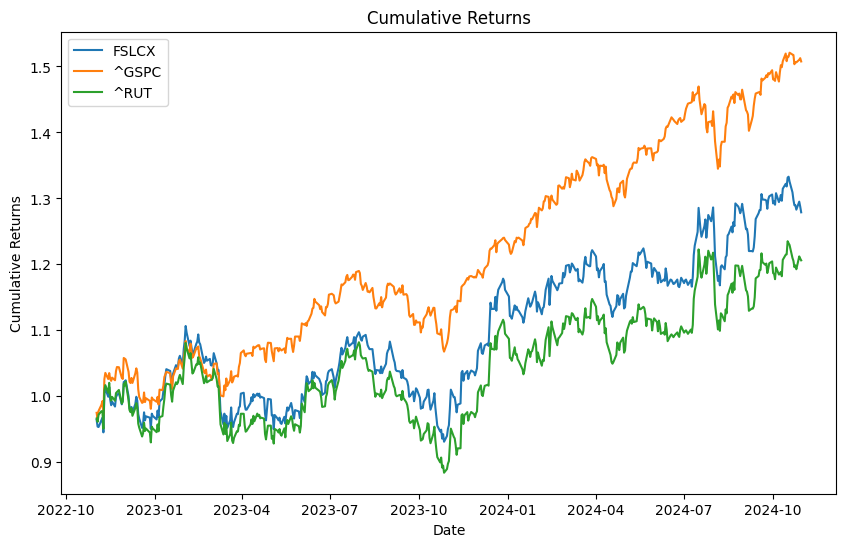

In [21]:
plt.figure(figsize=(10,6))
plt.plot(cum_returns)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(cum_returns.columns)
plt.show()

Volatility of the returns of the Fund, the Russel 2000 and the S&P500

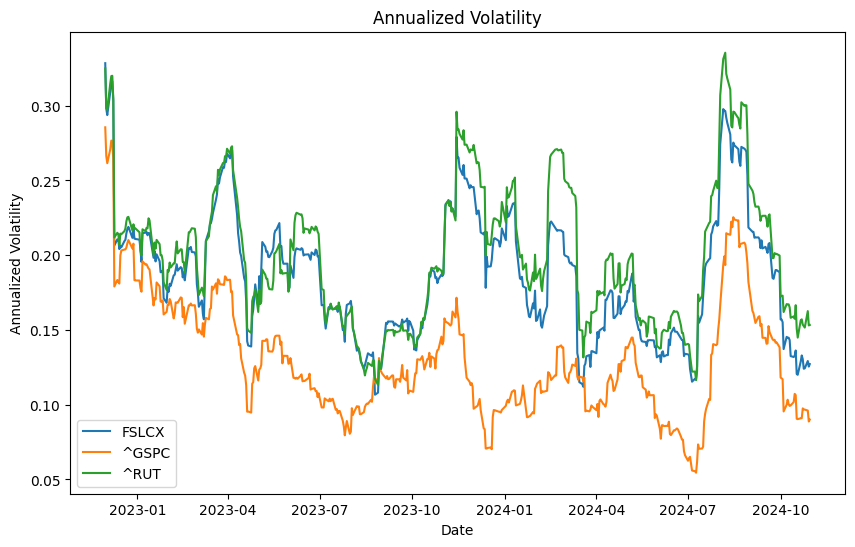

In [22]:
vol_all=returns.rolling(window).std()*np.sqrt(252)
plt.figure(figsize=(10,6))
plt.plot(vol_all)
plt.title('Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend(vol_all.columns)
plt.show()

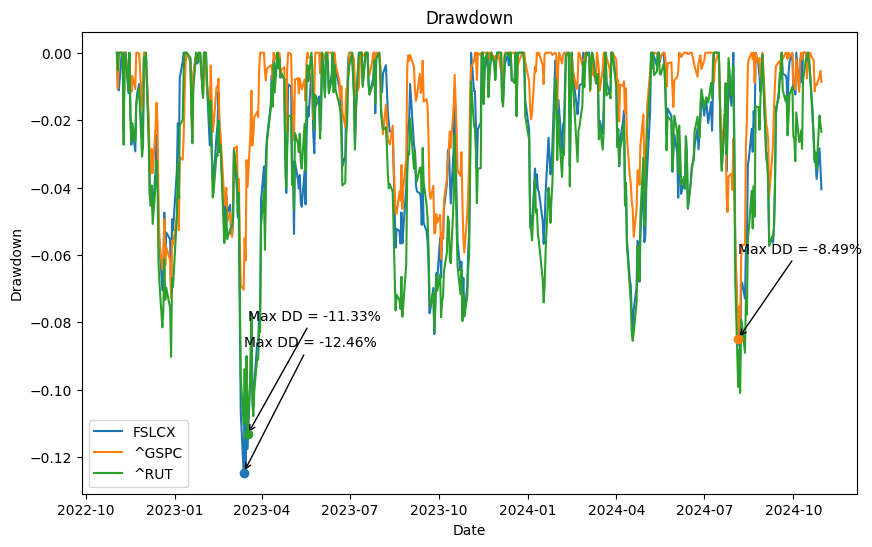

In [23]:
dd=MaxDD(returns,20)[1]
plt.figure(figsize=(10,6))
plt.plot(dd, label='Drawdown')

for col in dd.columns:
  plt.scatter(
      dd[col].idxmin(),
      dd[col].min(),
      zorder=5
  )
  plt.annotate(
      f"Max DD = {dd[col].min():.2%}",
      xy=(dd[col].idxmin(), dd[col].min()),
      xytext=(dd[col].idxmin(), dd[col].min() * 0.7),
      arrowprops=dict(arrowstyle="->")
  )
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend(dd.columns)
plt.show()

#Performance Indicators

##Sharpe ratio

In [24]:
summary_sharpe=pd.DataFrame({
    'Sharpe Ratio first year': SharpeRatio(returns_1st,risk_free[0]),
    'Sharpe Ratio second year': SharpeRatio(returns_2nd,risk_free[1]),
    'Sharpe Ratio all:': SharpeRatio(returns,risk_free[2])
})

In [25]:
summary_sharpe

,Sharpe Ratio first year,Sharpe Ratio second year,Sharpe Ratio all:
Ticker,,,
FSLCX,-0.387929,1.398347,0.497761
^GSPC,0.320118,2.334232,1.220966
^RUT,-0.662782,1.264610,0.337105


##Information Ratio

In [26]:
summary_information_ratio=pd.DataFrame({
    'Information Ratio first year': InformationRatio(returns_1st),
    'Information Ratio second year': InformationRatio(returns_2nd),
    'Information Ratio all:': InformationRatio(returns)
})

In [27]:
summary_information_ratio

,Information Ratio first year,Information Ratio second year,Information Ratio all:
^GSPC,-1.234349,-0.156036,-0.633430
^RUT,1.294876,-0.062377,0.581554


##Sortino Ratio

In [28]:
summary_sortino=pd.DataFrame({
    'Sortino Ratio first year': SortinoRatio(returns_1st['FSLCX'],risk_free[0]),
    'Sortino Ratio second year': SortinoRatio(returns_2nd['FSLCX'],risk_free[1]),
    'Sortino Ratio all:': SortinoRatio(returns['FSLCX'],risk_free[2])
}, index=['FSLCX'])

In [29]:
summary_sortino

,Sortino Ratio first year,Sortino Ratio second year,Sortino Ratio all:
FSLCX,-0.546056,2.149548,0.729893


##Jensen Alpha,Beta and R squared

In [30]:
risk_decompositon(risk_free[2],returns['FSLCX'],returns)

,^GSPC,^RUT
Alpha,-0.090201,0.033392
Beta,1.122115,0.915646
R-squared,0.649460,0.951194


##Heat Map

In [31]:
m1 = get_performance_metrics(returns_1st, risk_free[0])
m2 = get_performance_metrics(returns_2nd, risk_free[1])
m_all = get_performance_metrics(returns, risk_free[2])
comparison_df = pd.DataFrame({
    'Year 1': m1['Sortino'],
    'Year 2': m2['Sortino'],
    'Full Period': m_all['Sortino']
})

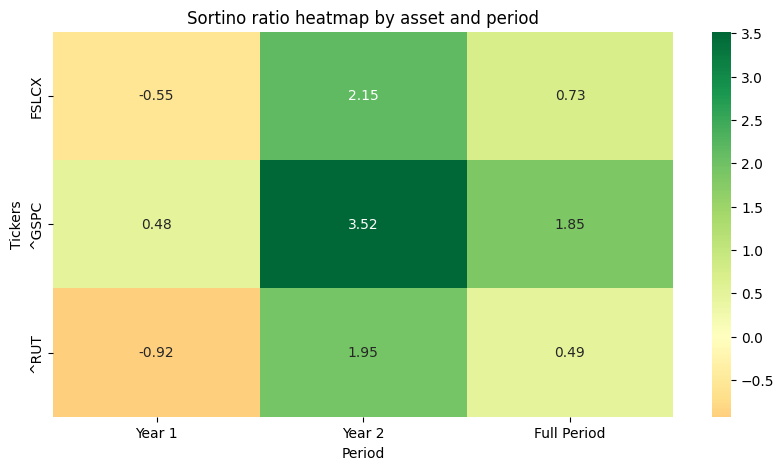

In [43]:
plt.figure(figsize=(10, 5))
sns.heatmap(comparison_df, annot=True, cmap='RdYlGn', center=0, fmt=".2f")
plt.title('Sortino ratio heatmap by asset and period')
plt.ylabel('Tickers')
plt.xlabel('Period')
plt.show()

##Rolling Beta

In [33]:
r_beta=rolling_beta(returns['FSLCX'],returns,risk_free[2],30)

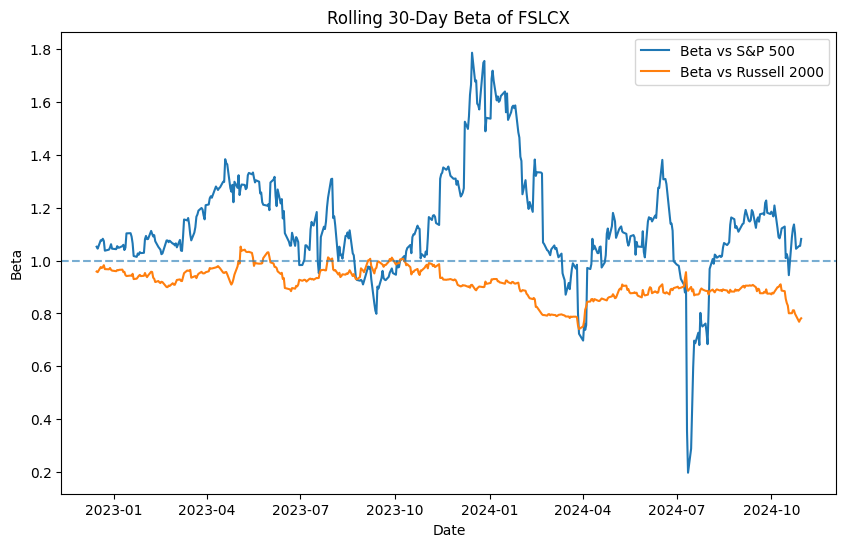

In [34]:
plt.figure(figsize=(10,6))
plt.plot(r_beta['^GSPC'], label='Beta vs S&P 500')
plt.plot(r_beta['^RUT'], label='Beta vs Russell 2000')
plt.axhline(1, linestyle='--', alpha=0.6)
plt.title('Rolling 30-Day Beta of FSLCX')
plt.ylabel('Beta')
plt.xlabel('Date')
plt.legend()
plt.show()

##Rolling TEV

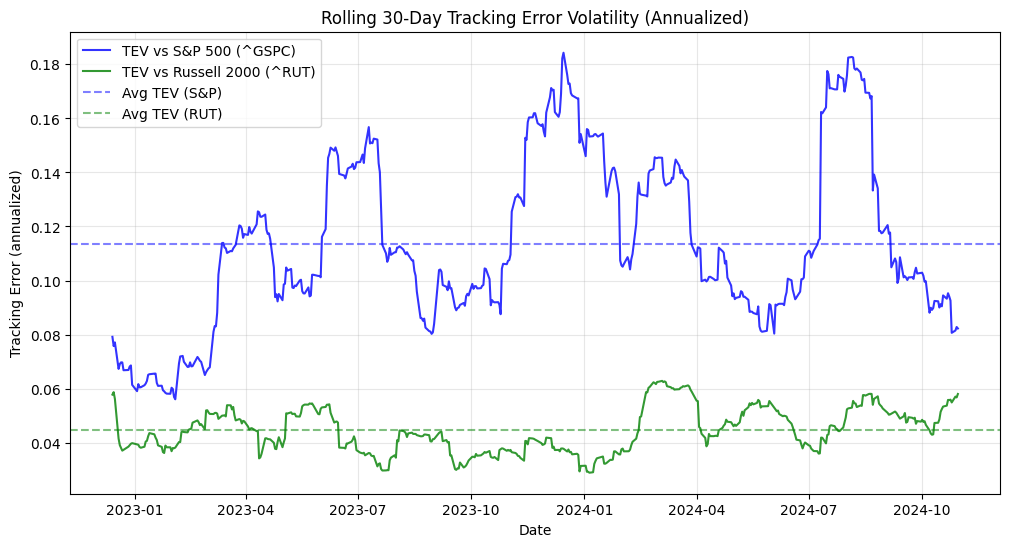

In [45]:
# Calculate rolling 60-day TEV for both benchmarks
tev_gspc = rolling_tev(returns['FSLCX'], returns['^GSPC'], window=30)
tev_rut = rolling_tev(returns['FSLCX'], returns['^RUT'], window=30)

plt.figure(figsize=(12, 6))
plt.plot(tev_gspc, label='TEV vs S&P 500 (^GSPC)', color='blue', alpha=0.8)
plt.plot(tev_rut, label='TEV vs Russell 2000 (^RUT)', color='green', alpha=0.8)

# Add styling
plt.axhline(tev_gspc.mean(), color='blue', linestyle='--', alpha=0.5, label='Avg TEV (S&P)')
plt.axhline(tev_rut.mean(), color='green', linestyle='--', alpha=0.5, label='Avg TEV (RUT)')

plt.title('Rolling 30-Day Tracking Error Volatility (Annualized)')
plt.ylabel('Tracking Error (annualized)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##Distribution plots

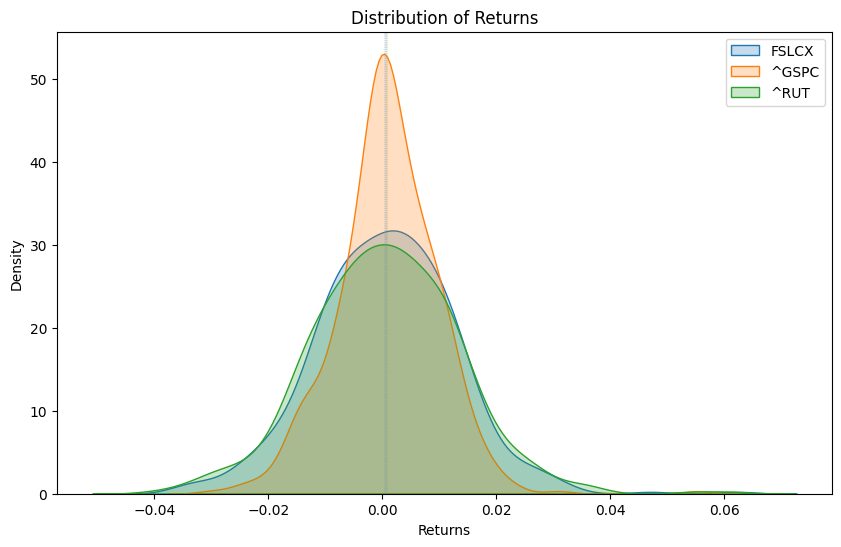

In [99]:
distribution(returns)


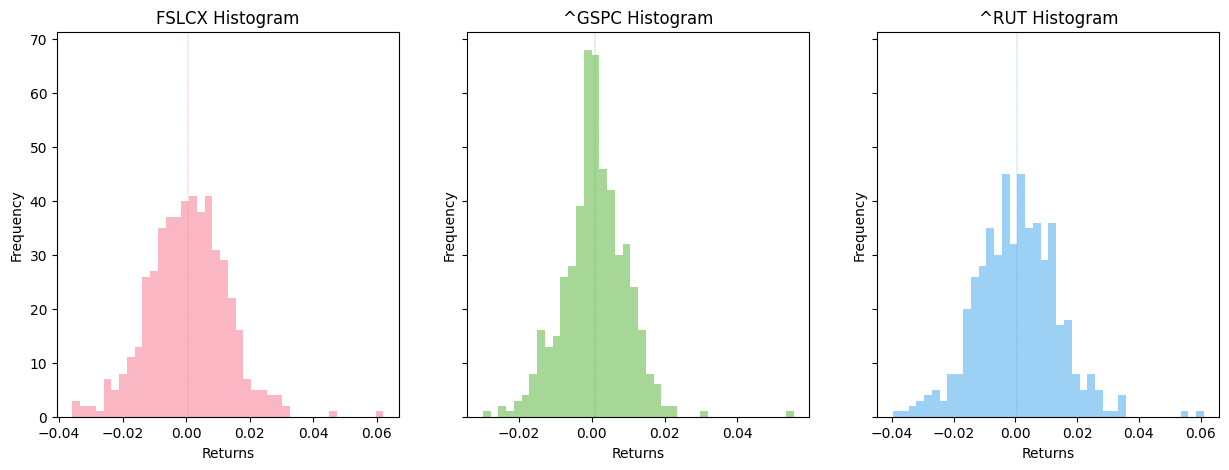

In [100]:
plt_histogram(returns)